<a href="https://colab.research.google.com/github/bartianbosch/Melk/blob/Jinli/Big_Data_Milk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Big Data Groupwork Milk** 


**Data Preparation**

Downloading and installing the necessary files

In [ ]:
# To download and update the necessary requirements, run this cell
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
# To initialize Apache Spark, run this cell
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
sp = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from google.colab import drive, files
drive.mount('/content/gdrive/')

**Import plot libraries**

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

import pandas as pd

from pyspark import SparkFiles

from pyspark.sql import types
from pyspark.sql import functions as psf
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.regression import LinearRegression

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pyspark.sql import functions as F

# imports used for removal of NULL values

from pyspark.sql import Window
from pyspark.sql.functions import last
import sys


Loading the original file in a Spark dataframe


In [ ]:
fileName = '/content/gdrive/MyDrive/Big_Data_Groupwork_Project/Big_Data_Groupwork/ff_dairy_v1.csv'
if not os.path.isfile(fileName):
  uploaded = files.upload()

spark.sparkContext.addFile(fileName)
milk_spark = spark.read.csv(SparkFiles.get(fileName), header=True)
milk_spark = milk_spark.repartitionByRange("Cow number")
print("Number of partitions: ", milk_spark.rdd.getNumPartitions())


Number of partitions:  101


First impression of the Spark dataframe containing the original data


In [ ]:
milk_spark.show(5)

+----------+-------+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+---------------------+---------+---------------------+-------------------------+-------+-----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+-------

**Select the variables**

Rename the columns with the unusable characters

In [ ]:
newColumnNames = list(map(lambda x: x.replace(".","").replace("�C","degC").replace("�I","plusI"), milk_spark.columns))

milk_spark1 = milk_spark.toDF(*newColumnNames)

Add an extra column for the fat yield 
(names: total_fat)

(Fat_yield = total_fat = fat% * milk_yield)

In [ ]:
# extra column total fat (fat yield)
# fat_yield = milk_yield * fat% -> the column is called total_fat ipv fat_yield 

milk_spark2 = milk_spark1.withColumn('total_fat', milk_spark1['Milk yield (kg)'] * milk_spark1['Fat%'])
milk_spark2_pd = milk_spark2.toPandas()

Fix the datatype 

In [ ]:
def fixType(datasetName, colName, dataType):
  """Takes a dataset and returns the dataset with the given column set to the given dataype"""
  return datasetName.withColumn(colName, F.col(colName).cast(dataType))

# Preparing Lists with the colum names and which type they need to be
allColumns = ['Cow number', 'Date', 'Barn', 'Barn part', 'Treatment', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)', 'Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Backfat Thickness', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Rumination time (min/day)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure dm (g/kg OM)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
doubleColumns = ['Intake basal ration (kg dm)', 'Intake total ration (kg dm)', 'Water intake (kg)', 'Concentrate intake (kg)', 'Weight (kg)', 'BCS', 'Milk yield (kg)', 'Fat%', 'Protein%', 'Lactose%', 'Avg Temperature (degC)', 'Air speed', 'Max temperature (degC)', 'Avg pH', 'Avg Rumen Temperature ', 'Time pH<5,8 (h)', 'Number of kernels', 'Manure sieving residu (%)', 'Manure starch (g/kg dm)', 'Urin-pH', 'Intake pre-period (kg dm)', 'Milk yield prepreriod (kg)', 'Fat% preperiod', 'Protein% preperiod', 'Fat preperiod (kg)', 'Protein preperiod (kg)', 'ECM preperiod (kg)', 'ECM (kg)', 'total_fat']
intColumns = ['Cow number', 'Barn', 'Barn part', 'Lactation number', 'Days in milk', 'Day number', 'Week', 'Backfat Thickness', 'Urea (mg/kg)', 'SCC (*1000/ml)', 'Rumination time (min/day)', 'Manure consistency (1=fluid, 5= hard)', 'Manure fibre score (1=short, 5 = long)', 'Manure dm (g/kg OM)', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)', 'nXP (g/day)', 'RNB (g/day)', 'MELK (g/day)', 'NEL (g/day)', 'WDE (g/day)', 'EKB (g/day)', 'WDS (g/day)', 'SPK (g/day)', 'TPK (g/day)', 'SPE (g/day)', 'TPE (g/day)', 'plusI (/day)', 'WI (/day)', 'GP (g/day)', 'Crude fiber (g/kg dm)', 'Sugar (g/kg dm)', 'Crude protein (g/kg dm)', 'Crude fat (g/kg dm)', 'Starch (g/kg dm)', 'Ca (g/kg dm)', 'P (g/kg dm)', 'Na (g/kg dm)', 'Cl (g/kg dm)', 'K (g/kg dm)', 'Mg (g/kg dm)', 'nXP (g/kg dm)', 'RNB (g/kg dm)', 'MELK (/kg dm)', 'NEL (MJ/kg dm)', 'WDE (g/kg dm)', 'EKB (g/kg dm)', 'WDS (g/kg dm)', 'SPK (g/kg dm)', 'TPK (g/kg dm)', 'SPE (g/kg dm)', 'TPE (g/kg dm)', 'plusI (/kg dm)', 'WI (/kg dm)', 'GP (g/kg dm)']
stringColumn = ['Treatment', 'Period (VP = preperiod, HP = trial period)', 'Period part (VP = preperiod, HP = trial period)']
milk_spark3 = milk_spark2

# Setting the columns to the correct type
for colName in doubleColumns:
  milk_spark3 = fixType(milk_spark3, colName, "double")
for colName in intColumns:
  milk_spark3 = fixType(milk_spark3, colName, "int")
milk_spark3 = milk_spark3.withColumn("Date", F.col("Date").cast("date"))



Select a subset with nutrients

(nutrients include: fat%, crude fiber, sugar, crude protein, crude fat, starch, Ca, P, Na, Cl, K, Mg)

In [ ]:
# crude fiber, sugar, crude protein, crude fat, starch, Ca, P, Na, Cl, K, Mg
# select the desired columns from the milk_spark3 dataframe
# null values are still included 


nutrients_selected = milk_spark3.select(['total_fat', 'Milk yield (kg)', 'Fat%', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 
                             'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)']).dropna(subset = "Fat%")
nutrients = nutrients_selected.select([nutrients_selected[col].cast('float') for col in nutrients_selected.columns])

nutrients_pd = nutrients.select('*').toPandas()
nutrients_pd[['total_fat', 'Milk yield (kg)', 'Fat%', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 
              'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)']] = nutrients_pd[['total_fat', 'Milk yield (kg)', 'Fat%', 'Crude fiber (g/day)', 'Sugar (g/day)', 'Crude protein (g/day)', 'Crude fat (g/day)', 'Starch (g/day)', 
              'Ca (g/day)', 'P (g/day)', 'Na (g/day)', 'Cl (g/day)', 'K (g/day)', 'Mg (g/day)']].apply(pd.to_numeric)


Fill possible NULL values and remove columns with too many NULL values

Unfortunatly not all NULL can be filled because some collumns start with NULL and backwards filling would provide unrealiable results

In [ ]:
inputColNames = doubleColumns + intColumns

In [ ]:
window = Window.partitionBy('Cow number').orderBy('Day number').rowsBetween(-sys.maxsize, 0)

for column in milk_spark3.columns:
  # define the forward-filled column
  filled_column = last(milk_spark3[column], ignorenulls=True).over(window)
  # do the fill 
  milk_spark4 = milk_spark3.withColumn(column, filled_column)

milk_data = milk_spark4.withColumn("Milk yield next day", F.lead("Milk yield (kg)", 1).over(Window.partitionBy('Cow number').orderBy('Day number')))
#intColumns.remove('Cow number')
milk_data = milk_data.drop('Cow number')

milk_data_pd = milk_data.toPandas()

**Variable names and datatypes**

milk_spark = Spark dataframe 
 - from spark.read_csv()
 - pyspark.sql.dataframe.DataFrame

milk_spark1 = Spark dataframe 
 - correct AVG temp, max temp and I (/day)

milk_spark2 = Spark dataframe
 - extra 'total_fat' column added -> last column is 'total' fat
 - can be converted to pandas using toPandas()

milk_spark2_pd = Pandas dataframe 
 - extra 'total_fat' column included -> last column is 'total' fat
 - derived from milk_data2

milk_spark3 = Spark dataframe
 - fixed datatype for all variables 

nutrients = Spark dataframe
 - selected the nutrients (Crude fiber and Ca etc)
 - pyspark.sql.dataframe.DataFrame

nutrients_pd = Pandas dataframe
 - convert nutrients to pandas 
 - also used: apply(pd.to_numeric) so expect numeric values ipv strings

milk_data = Spark dataframe
 - null values corrected 

milk_data_pd = Pandas dataframe
 - converted milk_data to pandas

In [ ]:
milk_data.show(5)



+----+----+---------+---------+----------------+------------+----------+----+------------------------------------------+-----------------------------------------------+---------------------------+---------------------------+-----------------+-----------------------+-----------+----+-----------------+---------------+----+--------+------------+--------------+--------+----------------------+---------+----------------------+-------------------------+------+----------------------+---------------+-------------------------------------+--------------------------------------+-----------------+-------------------------+-------------------+-----------------------+-------+-------------------------+--------------------------+--------------+------------------+------------------+----------------------+------------------+--------+-------------------+-------------+---------------------+-----------------+--------------+----------+---------+----------+----------+---------+----------+-----------+---------

# **Visualization**

**Scatterplots**

Just a simple scatterplot of one of the nutrients against the fat%, milk_yield and total_fat. The pairplot later shows the scatterplot of all nutrients. The scatterplots are created using seaborn.

In [ ]:
desired_nutrient = 'Ca (g/day)'

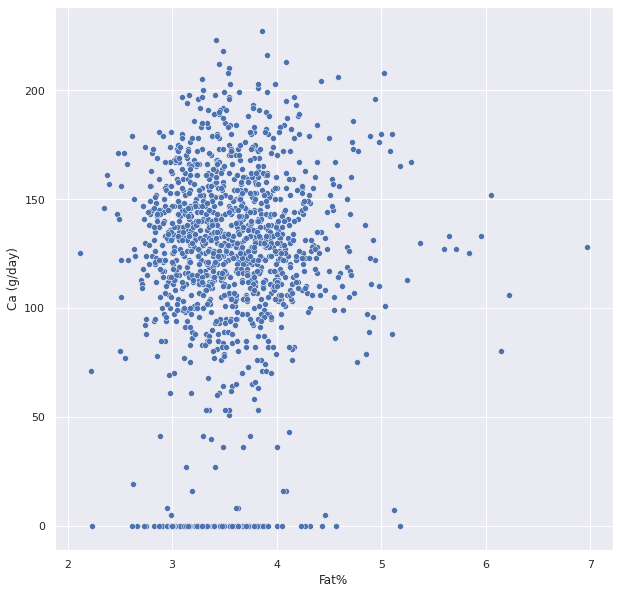

In [ ]:
# fat%
sns.scatterplot(x='Fat%', y=desired_nutrient, data=nutrients_pd)

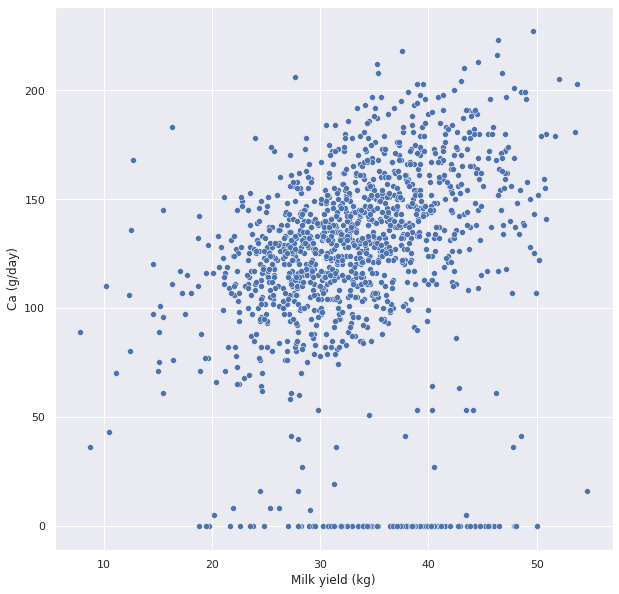

In [ ]:
# Milk yield
sns.scatterplot(x='Milk yield (kg)', y=desired_nutrient, data=nutrients_pd)

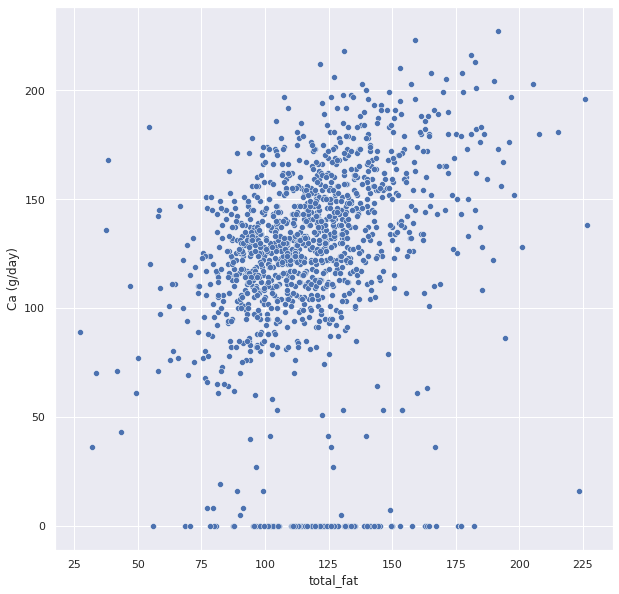

In [ ]:
# Total fat (fat yield)
sns.scatterplot(x='total_fat', y=desired_nutrient, data=nutrients_pd)

**Pairplot of the nutrients**

Used to find any direct visible correlations between any of the nutrients on the fat%, milk_yield and total_fat. Seaborn was used to create the pairplot. 

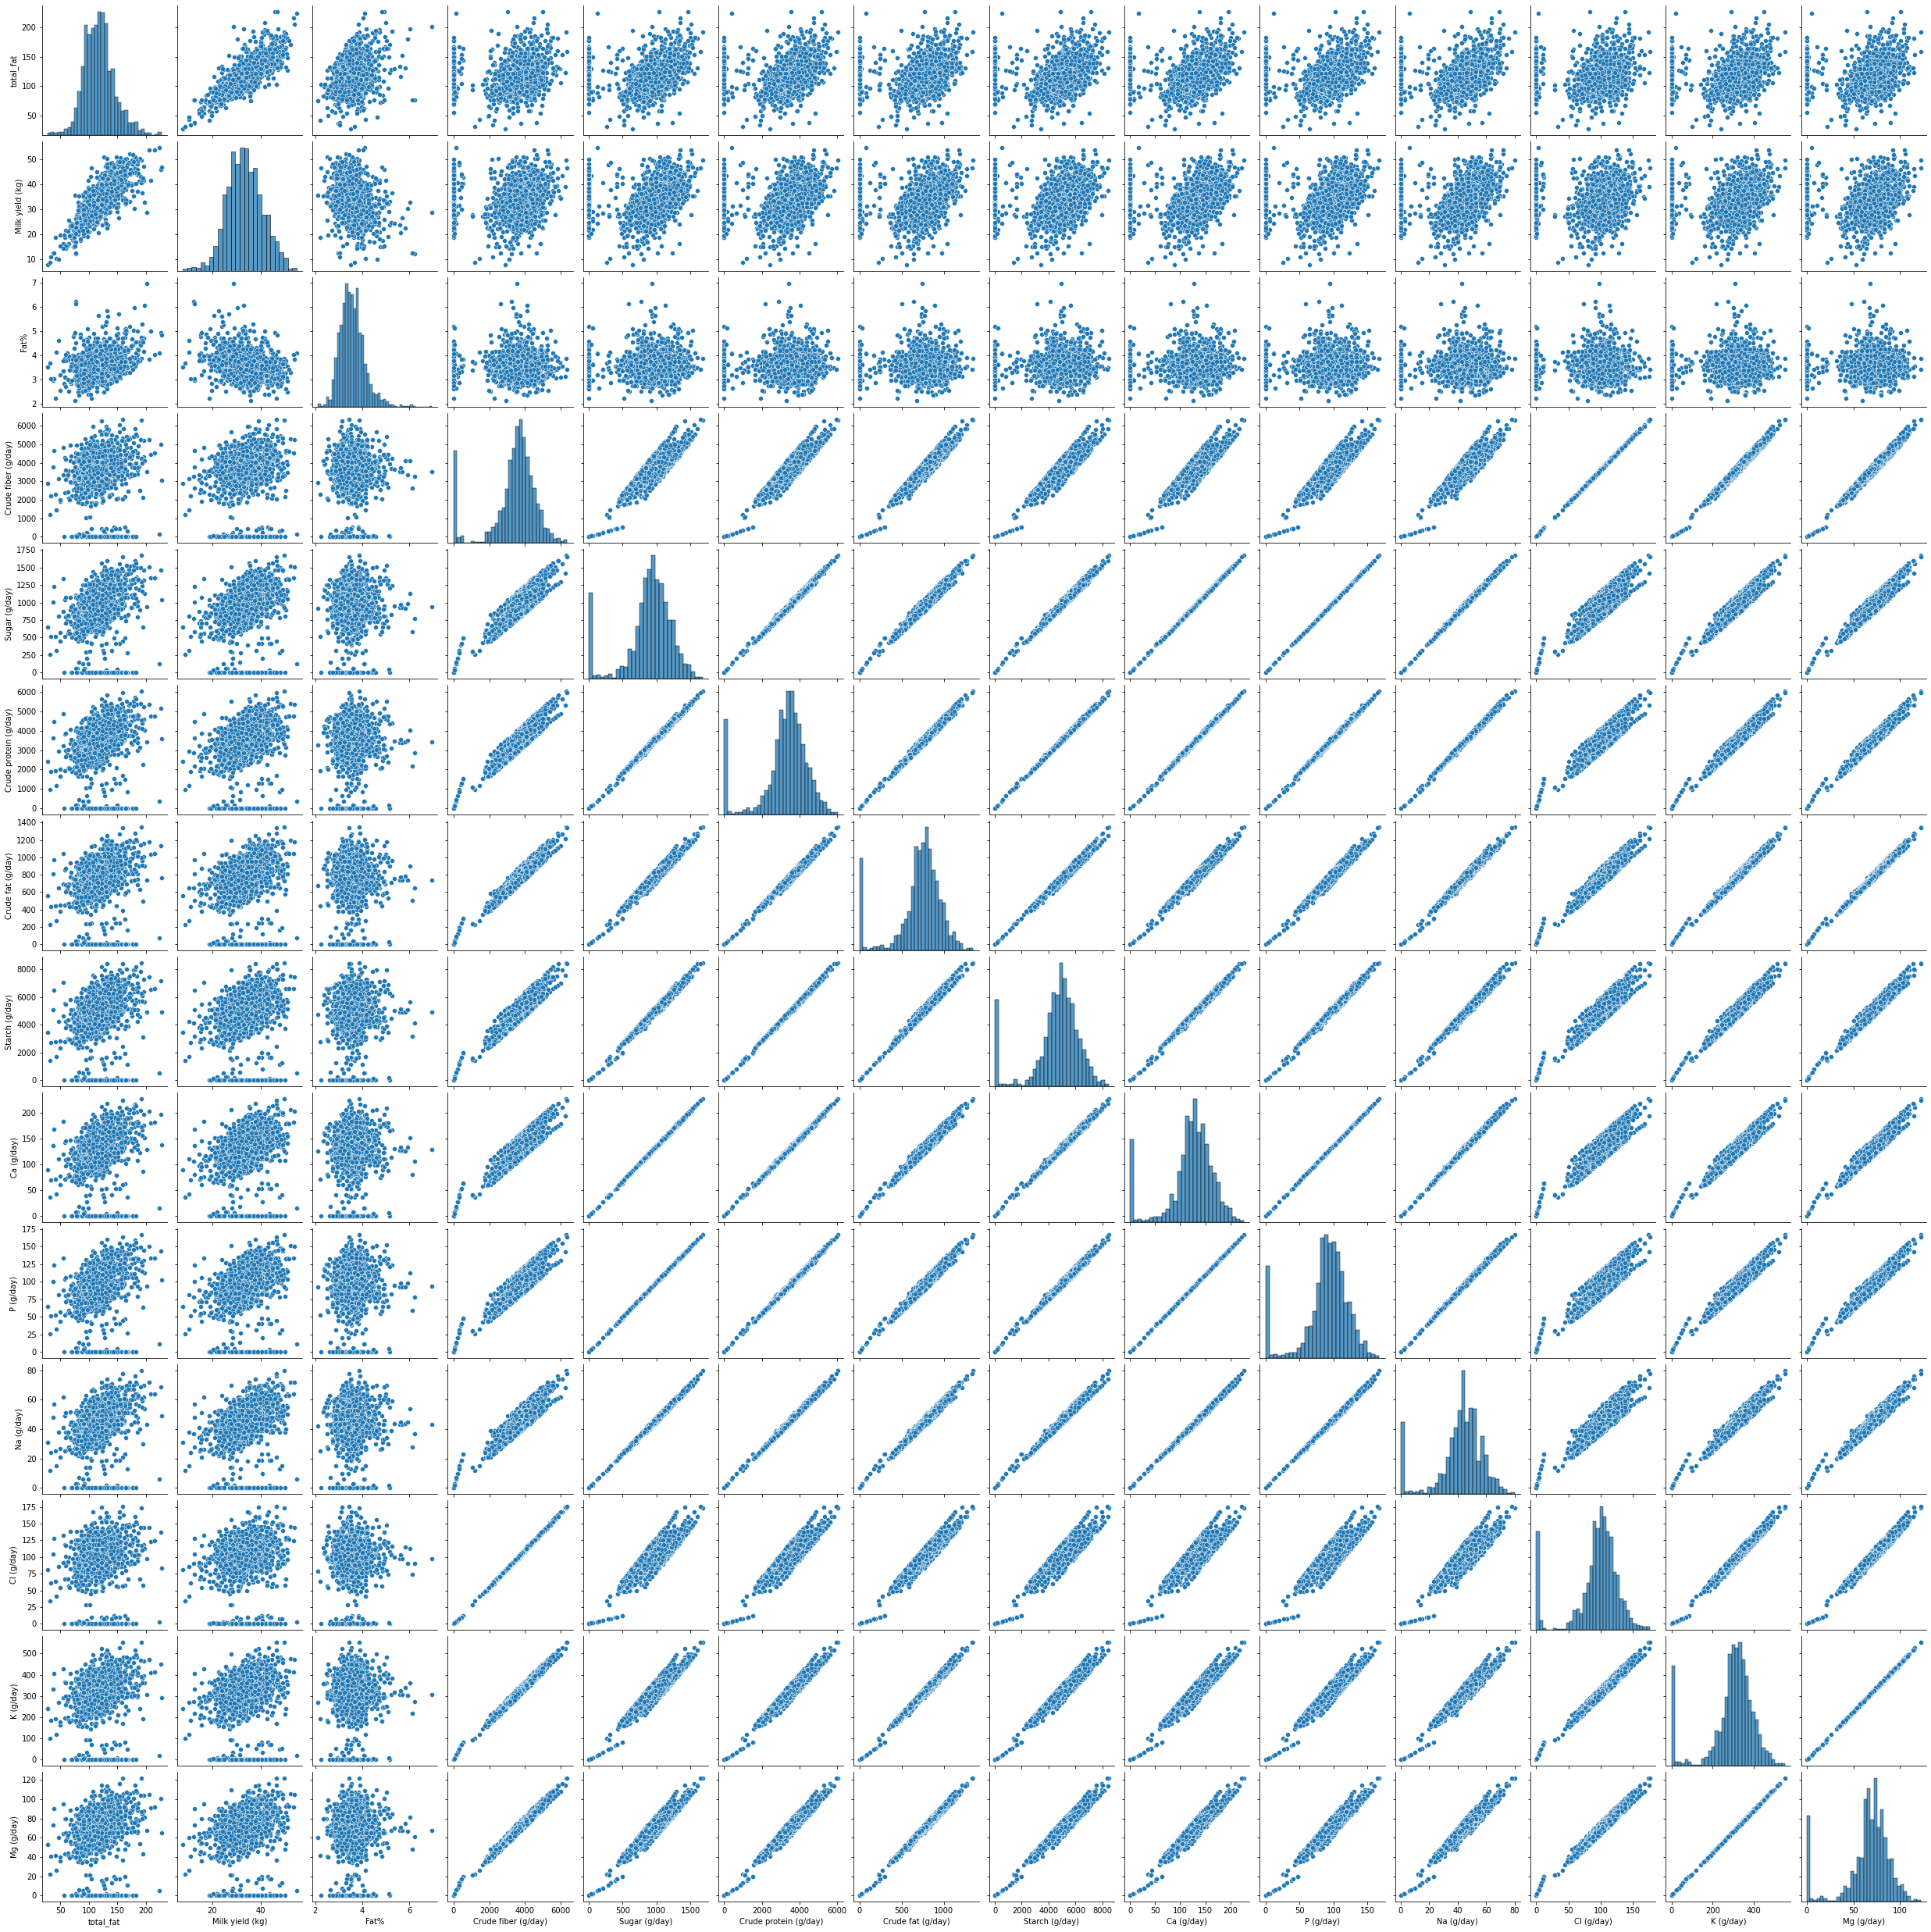

In [ ]:
# Basic correlogram
sns.pairplot(nutrients_pd)


**Correlation Matrix**

Correlation matrix for the nutrients

(nutrients include: fat%, crude fiber, sugar, crude protein, crude fat, starch, Ca, P, Na, Cl, K, Mg)

            cr_fiber     sugar  cr_protein  ...       fat  milk_yield  fat_yield
cr_fiber    1.000000  0.920108    0.945914  ...  0.058113    0.185966   0.204925
sugar       0.920108  1.000000    0.996981  ...  0.060018    0.363698   0.392010
cr_protein  0.945914  0.996981    1.000000  ...  0.061772    0.328290   0.356898
cr_fat      0.970026  0.986463    0.994072  ...  0.057351    0.308087   0.330622
starch      0.948322  0.991665    0.997758  ...  0.065800    0.303278   0.335503
ca          0.928116  0.999473    0.998639  ...  0.061654    0.349623   0.378943
p           0.925900  0.999722    0.998196  ...  0.060955    0.354303   0.383068
na          0.930450  0.997964    0.995902  ...  0.056754    0.363391   0.388112
cl          0.999549  0.909352    0.936698  ...  0.057101    0.175093   0.192790
k           0.991942  0.962207    0.978965  ...  0.058828    0.248485   0.270316
mg          0.988847  0.967683    0.982809  ...  0.059157    0.259200   0.281549
fat         0.058113  0.0600

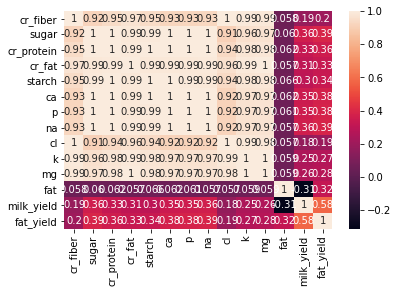

In [ ]:
# create column dataframe without NULL values -> returns a series object
cr_fiber_col2 = milk_data_pd.loc[:,'Crude fiber (g/day)']
sugar_col2 = milk_data_pd.loc[:,'Sugar (g/day)']
cr_protein_col2 = milk_data_pd.loc[:,'Crude protein (g/day)']
cr_fat_col2 = milk_data_pd.loc[:,'Crude fat (g/day)']
starch_col2 = milk_data_pd.loc[:,'Starch (g/day)']

ca_col2 = milk_data_pd.loc[:,'Ca (g/day)']
p_col2 = milk_data_pd.loc[:,'P (g/day)']
na_col2 = milk_data_pd.loc[:,'Na (g/day)']
cl_col2 = milk_data_pd.loc[:,'Cl (g/day)']
k_col2 = milk_data_pd.loc[:,'K (g/day)']
mg_col2 = milk_data_pd.loc[:,'Mg (g/day)']

fat_col2 = milk_data_pd.loc[:,'Fat%']
milk_yield_col2 = milk_data_pd.loc[:,'Milk yield (kg)']
fat_yield_col2 = milk_data_pd.loc[:,'total_fat']

# create a list/array from the columns -> returns a list/array
cr_fiber_array = cr_fiber_col2.values
sugar_array = sugar_col2.values
cr_protein_array = cr_protein_col2.values
cr_fat_array = cr_fat_col2.values
starch_array = starch_col2.values

ca_array = ca_col2.values
p_array = p_col2.values
na_array = na_col2.values
cl_array = cl_col2.values
k_array = k_col2.values
mg_array = mg_col2.values

fat_array = fat_col2.values
milk_yield_array = milk_yield_col2.values
fat_yield_array = fat_yield_col2.values

# create a dictionary from the arrays

data_dict = {'cr_fiber': cr_fiber_array, 
             'sugar':sugar_array,
             'cr_protein':cr_protein_array,
             'cr_fat':cr_fat_array,
             'starch':starch_array,
             'ca':ca_array,
             'p':p_array,
             'na':na_array,
             'cl':cl_array,
             'k':k_array,
             'mg':mg_array,
             'fat':fat_array,
             'milk_yield':milk_yield_array,
             'fat_yield':fat_yield_array}

# create a panda dataframe from the dictionary

nutrients_pd_df = pd.DataFrame(data_dict, columns=['cr_fiber', 'sugar', 'cr_protein', 'cr_fat', 'starch', 'ca', 'p', 'na', 'cl', 'k', 'mg', 'fat', 'milk_yield', 'fat_yield'])

#print(nutrients_pd_df.dtypes) 
# -> test if all column datatypes are float64


# create a correlation matrix

corrMatrix = nutrients_pd_df.corr()
print(corrMatrix)

# plot the correlation matrix

sns.heatmap(corrMatrix, annot=True)
plt.show()

Correlation matrix for the conditions and preperiod fat%, milk yield 

(conditions include: Intake basal ration (kg dm), Intake total ration (kg dm), Water intake (kg), Concentrate intake (kg), Weight (kg), Avg Temperature (degC), Max temperature (degC) ) 

              total_intake     water  ...  milk_yield  fat_yield
total_intake      1.000000  0.466425  ...    0.382634   0.397593
water             0.466425  1.000000  ...    0.494031   0.453320
conc_intake       0.482197  0.526487  ...    0.534643   0.559332
weight            0.396282  0.214633  ...    0.099203   0.279244
avgtemp          -0.074519  0.199163  ...   -0.017924   0.026931
maxtemp          -0.067644  0.191300  ...   -0.001245   0.046900
milk_pre          0.489364  0.580407  ...    0.679524   0.561260
fat_pre           0.106662  0.036010  ...   -0.152583   0.326377
fat              -0.009679 -0.097577  ...   -0.310436   0.319845
milk_yield        0.382634  0.494031  ...    1.000000   0.575864
fat_yield         0.397593  0.453320  ...    0.575864   1.000000

[11 rows x 11 columns]


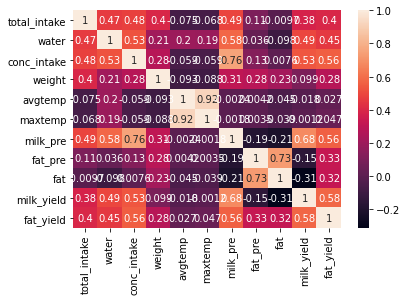

In [ ]:
#Intake basal ration (kg dm), Intake total ration (kg dm), Water intake (kg), Concentrate intake (kg), Weight (kg), Avg Temperature (degC), Max temperature (degC)
# Milk yield prepreriod (kg), Fat% preperiod

# create column dataframe = -> returns a series object
total_intake_col2 = milk_data_pd.loc[:,'Intake total ration (kg dm)']
water_col2 = milk_data_pd.loc[:,'Water intake (kg)']
conc_intake_col2 = milk_data_pd.loc[:,'Concentrate intake (kg)']
weight_col2 = milk_data_pd.loc[:,'Weight (kg)']
avgtemp_col2 = milk_data_pd.loc[:,'Avg Temperature (degC)']
maxtemp_col2 = milk_data_pd.loc[:,'Max temperature (degC)']

milk_pre_col2 = milk_data_pd.loc[:,'Milk yield prepreriod (kg)']
fat_pre_col2 = milk_data_pd.loc[:,'Fat% preperiod']

fat_col2 = milk_data_pd.loc[:,'Fat%']
milk_yield_col2 = milk_data_pd.loc[:,'Milk yield (kg)']
fat_yield_col2 = milk_data_pd.loc[:,'total_fat']

# create a list/array from the columns -> returns a list/array
total_intake_array = total_intake_col2.values
water_array = water_col2.values
conc_intake_array = conc_intake_col2.values
weight_array = weight_col2.values
avgtemp_array = avgtemp_col2.values
maxtemp_array = maxtemp_col2.values

milk_pre_array = milk_pre_col2.values
fat_pre_array = fat_pre_col2.values

fat_array = fat_col2.values
milk_yield_array = milk_yield_col2.values
fat_yield_array = fat_yield_col2.values

# create a dictionary from the arrays

data_dict = {'total_intake': total_intake_array, 
             'water':water_array,
             'conc_intake':conc_intake_array,
             'weight':weight_array,
             'avgtemp':avgtemp_array,
             'maxtemp':maxtemp_array,
             'milk_pre':milk_pre_array,
             'fat_pre':fat_pre_array,
             'fat':fat_array ,
             'milk_yield':milk_yield_array,
             'fat_yield':fat_yield_array,
             }

# create a panda dataframe from the dictionary

nutrients_pd_df = pd.DataFrame(data_dict, columns=['total_intake', 'water', 'conc_intake', 'weight', 'avgtemp', 'maxtemp', 'milk_pre', 'fat_pre', 'fat', 'milk_yield', 'fat_yield'])

#print(nutrients_pd_df.dtypes) 
# -> test if all column datatypes are float64


# create a correlation matrix

corrMatrix = nutrients_pd_df.corr()
print(corrMatrix)

# plot the correlation matrix

sns.heatmap(corrMatrix, annot=True)
plt.show()

**Simple scatterplot**

In [ ]:
### CHANGE inputColNames (list of x) AND LabelColName (y) TO CREATE THE
### DESIRED PLOTS. # ONLY 10 x VALUES CAN BE ENTERED AT A TIME -> otherwise empty plots will be created

inputColNames = doubleColumns[0:10]

labelColName = 'total_fat'
predictionColName = "Predicted " + labelColName

# Removing the label column from the input column if it ended in there on accident
if labelColName in inputColNames: inputColNames.remove(labelColName)

milk_subset = milk_data.select(inputColNames+[labelColName])

<Figure size 720x720 with 0 Axes>

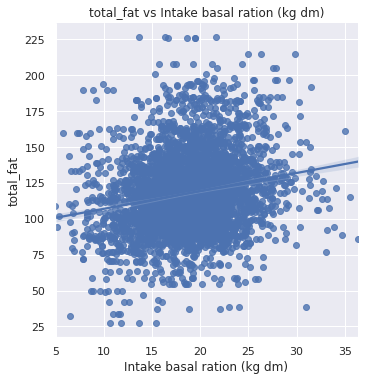

<Figure size 720x720 with 0 Axes>

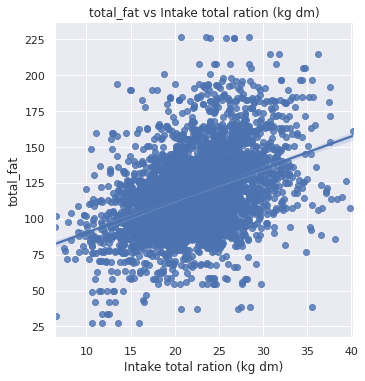

<Figure size 720x720 with 0 Axes>

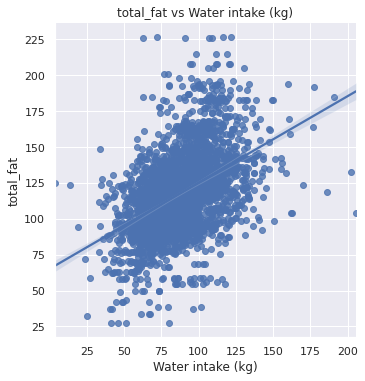

<Figure size 720x720 with 0 Axes>

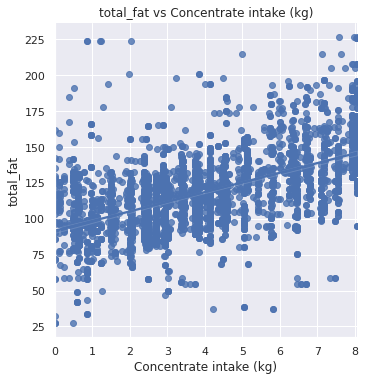

<Figure size 720x720 with 0 Axes>

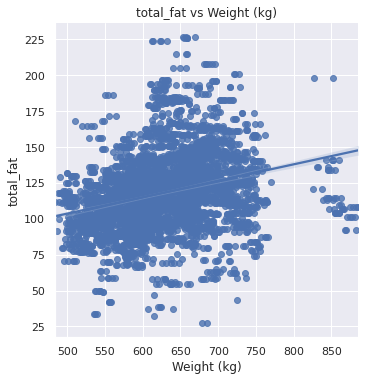

<Figure size 720x720 with 0 Axes>

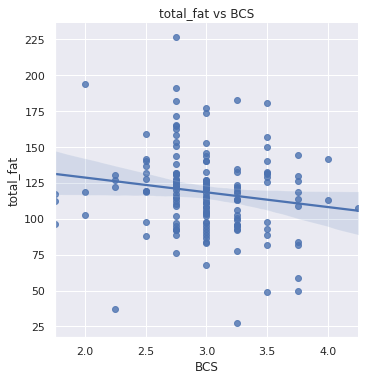

<Figure size 720x720 with 0 Axes>

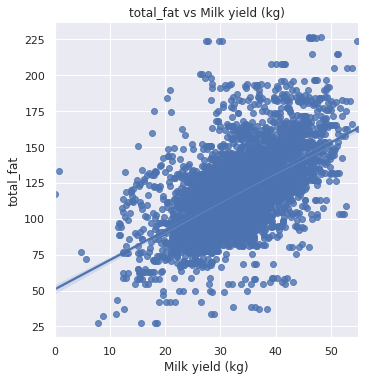

<Figure size 720x720 with 0 Axes>

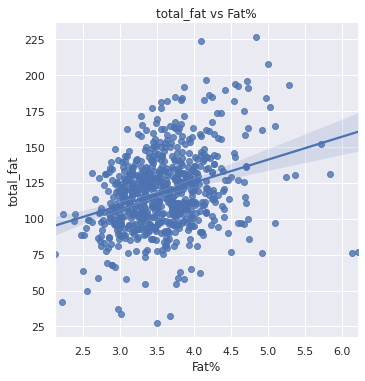

<Figure size 720x720 with 0 Axes>

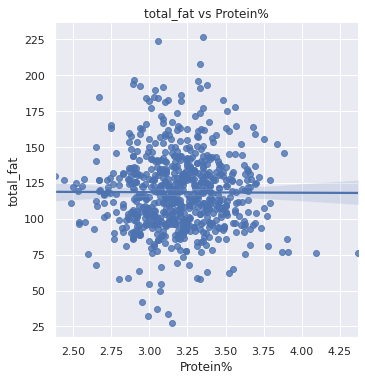

<Figure size 720x720 with 0 Axes>

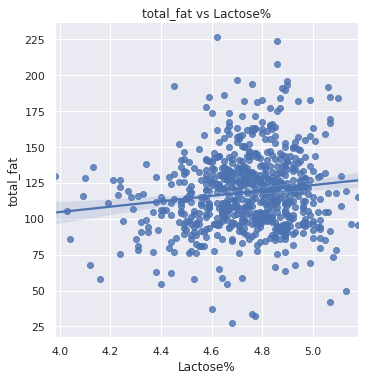

In [ ]:
## Plotting the columns versus the labelcolumn to get inital idea of linear regression

milk_sample = milk_subset.select(inputColNames+[labelColName]).sample(False,0.5)

sns.set(rc={'figure.figsize':(10,10)})

for column in inputColNames:
  plt.figure()
  sns.lmplot(x=column, y=labelColName,data=milk_sample.toPandas())
  plt.title(labelColName+" vs "+column)
  plt.xlabel(column)
  plt.ylabel(labelColName)

**Calculation of VIF values for the nutrients**

In [ ]:
# convert the nutrients columns to a list

cr_fiber_list = milk_data_pd['Crude fiber (g/day)'].tolist()
sugar_list = milk_data_pd['Sugar (g/day)'].tolist()
cr_protein_list = milk_data_pd['Crude protein (g/day)'].tolist()
cr_fat_list = milk_data_pd['Crude fat (g/day)'].tolist()
starch_list = milk_data_pd['Starch (g/day)'].tolist()


ca_list = milk_data_pd['Ca (g/day)'].tolist()
p_list = milk_data_pd['P (g/day)'].tolist()
na_list = milk_data_pd['Na (g/day)'].tolist()
cl_list = milk_data_pd['Cl (g/day)'].tolist()
k_list = milk_data_pd['K (g/day)'].tolist()
mg_list = milk_data_pd['Mg (g/day)'].tolist()

fat_list = milk_data_pd['Fat%'].tolist()
milk_yield_list = milk_data_pd['Milk yield (kg)'].tolist()
total_fat_list = milk_data_pd['total_fat'].tolist()

# create a dataframe from a library containing all the nutrient lists

nutrients_df = pd.DataFrame({'ca':ca_list, 'sugar':sugar_list, 'cr_protein':cr_protein_list, 'cr_fat':cr_fat_list, 'starch':starch_list, 
                             'ca':ca_list, 'p':p_list, 'na':na_list, 'cl':cl_list, 'k':k_list, 'mg':mg_list, 
                             'fat':fat_list, 'milk_yield':milk_yield_list, 'total_fat':total_fat_list})


In [ ]:
#find design matrix for linear regression model using 'ca' as response variable 

y, X = dmatrices('ca ~ sugar+cr_protein+cr_fat+starch+p+na+cl+k+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   8.072534e+02   Intercept
1   8.974041e+05       sugar
2   4.979599e+06  cr_protein
3   4.724505e+05      cr_fat
4   7.710255e+05      starch
5   1.574097e+04           p
6   3.341387e+03          na
7   1.574716e+04          cl
8   1.192427e+05           k
9   8.167349e+03          mg
10  1.628290e+01         fat
11  3.803732e+01  milk_yield
12  3.880307e+01   total_fat


In [ ]:
#find design matrix for linear regression model using 'sugar' as response variable 

y, X = dmatrices('sugar ~ ca+cr_protein+cr_fat+starch+p+na+cl+k+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

              VIF    variable
0      807.697164   Intercept
1    28241.159418          ca
2   893702.625722  cr_protein
3   419550.299734      cr_fat
4   266251.587953      starch
5    15736.931071           p
6     3342.836910          na
7    15166.462688          cl
8   101906.690189           k
9     8166.104693          mg
10      16.287908         fat
11      38.060775  milk_yield
12      38.818670   total_fat


In [ ]:
#find design matrix for linear regression model using 'cr_protein' as response variable 

y, X = dmatrices('cr_protein ~ sugar+ca+cr_fat+starch+p+na+cl+k+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

              VIF    variable
0      807.655599   Intercept
1   163163.203110       sugar
2    28610.012766          ca
3   257267.657782      cr_fat
4    38090.438705      starch
5    15732.321719           p
6     3335.261091          na
7    15747.359194          cl
8   117774.444814           k
9     8171.872410          mg
10      16.287786         fat
11      38.057976  milk_yield
12      38.817325   total_fat


In [ ]:
#find design matrix for linear regression model using 'cr_fat' as response variable 

y, X = dmatrices('cr_fat ~ sugar+cr_protein+ca+starch+p+na+cl+k+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   8.074694e+02   Intercept
1   8.071289e+05       sugar
2   2.710909e+06  cr_protein
3   2.860287e+04          ca
4   2.591489e+05      starch
5   1.576737e+04           p
6   3.342765e+03          na
7   1.467526e+04          cl
8   8.591215e+04           k
9   8.124329e+03          mg
10  1.627973e+01         fat
11  3.804735e+01  milk_yield
12  3.879007e+01   total_fat


In [ ]:
#find design matrix for linear regression model using 'starch' as response variable 

y, X = dmatrices('starch ~ sugar+cr_protein+cr_fat+ca+p+na+cl+k+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

              VIF    variable
0      807.587815   Intercept
1   313956.986292       sugar
2   246016.780622  cr_protein
3   158843.139056      cr_fat
4    28611.534737          ca
5    15763.441406           p
6     3327.024278          na
7    15642.231738          cl
8   118792.326204           k
9     8170.571523          mg
10      16.286739         fat
11      38.053658  milk_yield
12      38.813057   total_fat


In [ ]:
#find design matrix for linear regression model using 'p' as response variable 

y, X = dmatrices('p ~ sugar+cr_protein+cr_fat+starch+ca+na+cl+k+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   8.044392e+02   Intercept
1   9.075705e+05       sugar
2   4.969629e+06  cr_protein
3   4.726730e+05      cr_fat
4   7.709628e+05      starch
5   2.856842e+04          ca
6   3.340654e+03          na
7   1.573867e+04          cl
8   1.192600e+05           k
9   8.171973e+03          mg
10  1.620010e+01         fat
11  3.786478e+01  milk_yield
12  3.858825e+01   total_fat


In [ ]:
#find design matrix for linear regression model using 'na' as response variable 

y, X = dmatrices('na ~ sugar+cr_protein+cr_fat+starch+p+ca+cl+k+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   8.077320e+02   Intercept
1   9.095190e+05       sugar
2   4.970468e+06  cr_protein
3   4.727631e+05      cr_fat
4   7.676701e+05      starch
5   1.576042e+04           p
6   2.861000e+04          ca
7   1.574017e+04          cl
8   1.192918e+05           k
9   8.172099e+03          mg
10  1.628726e+01         fat
11  3.806442e+01  milk_yield
12  3.881394e+01   total_fat


In [ ]:
#find design matrix for linear regression model using 'cl' as response variable 

y, X = dmatrices('cl ~ sugar+cr_protein+cr_fat+starch+p+na+ca+k+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   8.077344e+02   Intercept
1   8.760265e+05       sugar
2   4.982089e+06  cr_protein
3   4.406155e+05      cr_fat
4   7.662204e+05      starch
5   1.576307e+04           p
6   3.341533e+03          na
7   2.862395e+04          ca
8   1.153165e+05           k
9   8.163189e+03          mg
10  1.628662e+01         fat
11  3.806253e+01  milk_yield
12  3.880998e+01   total_fat


In [ ]:
#find design matrix for linear regression model using 'k' as response variable 

y, X = dmatrices('k ~ sugar+cr_protein+cr_fat+starch+p+na+cl+ca+mg+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   8.077018e+02   Intercept
1   7.770130e+05       sugar
2   4.918667e+06  cr_protein
3   3.405033e+05      cr_fat
4   7.681323e+05      starch
5   1.576740e+04           p
6   3.343025e+03          na
7   1.522244e+04          cl
8   2.861224e+04          ca
9   8.066660e+03          mg
10  1.628519e+01         fat
11  3.806336e+01  milk_yield
12  3.881056e+01   total_fat


In [ ]:
#find design matrix for linear regression model using 'mg' as response variable 

y, X = dmatrices('mg ~ sugar+cr_protein+cr_fat+starch+p+na+cl+k+ca+fat+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   8.071075e+02   Intercept
1   9.089212e+05       sugar
2   4.982000e+06  cr_protein
3   4.700455e+05      cr_fat
4   7.712333e+05      starch
5   1.577168e+04           p
6   3.343092e+03          na
7   1.573034e+04          cl
8   1.177550e+05           k
9   2.860796e+04          ca
10  1.626145e+01         fat
11  3.804199e+01  milk_yield
12  3.877044e+01   total_fat


In [ ]:
#find design matrix for linear regression model using 'fat%' as response variable 

y, X = dmatrices('fat ~ sugar+cr_protein+cr_fat+starch+p+na+cl+k+mg+ca+milk_yield+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   3.477272e+01   Intercept
1   9.095879e+05       sugar
2   4.982098e+06  cr_protein
3   4.725718e+05      cr_fat
4   7.713217e+05      starch
5   1.568689e+04           p
6   3.342957e+03          na
7   1.574626e+04          cl
8   1.192742e+05           k
9   8.158822e+03          mg
10  2.861579e+04          ca
11  2.797927e+00  milk_yield
12  2.749583e+00   total_fat


In [ ]:
#find design matrix for linear regression model using 'milk_yield' as response variable 

y, X = dmatrices('milk_yield ~ sugar+cr_protein+cr_fat+starch+p+na+cl+k+mg+fat+ca+total_fat', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   5.641184e+01   Intercept
1   9.094999e+05       sugar
2   4.981287e+06  cr_protein
3   4.725965e+05      cr_fat
4   7.711582e+05      starch
5   1.568918e+04           p
6   3.343087e+03          na
7   1.574671e+04          cl
8   1.192907e+05           k
9   8.167270e+03          mg
10  1.197242e+00         fat
11  2.860418e+04          ca
12  1.606129e+00   total_fat


In [ ]:
#find design matrix for linear regression model using 'total_fat' as response variable 

y, X = dmatrices('total_fat ~ sugar+cr_protein+cr_fat+starch+p+na+cl+k+mg+fat+milk_yield+ca', data=nutrients_df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

print(vif)

             VIF    variable
0   1.110750e+02   Intercept
1   9.095873e+05       sugar
2   4.981959e+06  cr_protein
3   4.724604e+05      cr_fat
4   7.712650e+05      starch
5   1.567828e+04           p
6   3.342680e+03          na
7   1.574397e+04          cl
8   1.192691e+05           k
9   8.161937e+03          mg
10  1.153696e+00         fat
11  1.574922e+00  milk_yield
12  2.861306e+04          ca
